# **Predict consumption at cluster level**


In this project a **Ridge Regression model** is used to predict the consumption levels using the extracted feature vector.

- **Ridge regression** is a **linear regression** technique with **L2 regularization**, and the **regularization strength** is controlled by the **alpha** parameter.

- Linear regression is a supervised learning algorithm used for predicting a continuous target variable based on one or more predictor features.

- It works by finding the coefficients that minimize the sum of squared errors between the predicted values and the actual values.

- L2 regularization adds a penalty term to the linear regression cost function. This penalty term is the sum of the squares of the coefficients (weights) of the regression model.

- It includes a regularization parameter, which helps to prevent overfitting by shrinking the coefficients towards zero.

- The alpha parameter determines the trade-off between fitting the training data well and keeping the model's coefficients small.

- A higher alpha leads to greater regularization, which can prevent overfitting but may result in a less flexible model.

- Ridge Regression model is less prone to overfitting than other linear regression model.

Input and output variables:

  - the input variable is the feature vector that is computed for each cluster of images.

  - the output variable is the log of the consumption level for that cluster.













### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Add absolute path to the project folder

In [2]:
import sys

sys.path.append("/content/drive/MyDrive/UNECA_MachineLearning_Project/")

# See the full list of paths in sys.path
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/UNECA_MachineLearning_Project/']

## Import libraries and modules

In [3]:
# Provides a way to interact with the operating system
import os

# A library for numerical computations in Python.
import numpy as np

# A library for data manipulation and analysis
import pandas as pd

# useful for saving and loading Python objects.
import pickle

# A plotting library for creating visualizations.
import matplotlib.pyplot as plt

# Importing the plotly.express library for interactive plots.
import plotly.express as px

# Importing the plotly.graph_objects library for interactive plots.
import plotly.graph_objects as go

# Provides functions for generating random numbers.
import random

# Used for statistical analysis (descriptive statistics, probability distributions, and statistical tests)
from scipy import stats

# Provides a way to standardize features by removing the mean and scaling to unit variance.
from sklearn.preprocessing import StandardScaler

# It enables k-fold cross-validation by splitting the dataset into k folds and training/testing the model k times.
from sklearn.model_selection import KFold

# It includes various linear models for regression and classification tasks [Linear Regression or Logistic Regression]
import sklearn.linear_model as linear_model

# It provides various metrics for evaluating machine learning models [accuracy, precision, recall, F1 score]
import sklearn.metrics as metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# It performs k-means clustering and useful in unsupervised machine learning for grouping data points.
from sklearn.cluster import KMeans

### Add Base Directory

In [4]:
# Sets the base directory variable
BASE_DIR = '/content/drive/MyDrive/UNECA_MachineLearning_Project/'

In [5]:
# Change the current working directory
os.chdir(BASE_DIR)

# Print the current working directory to verify the change
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/drive/MyDrive/UNECA_MachineLearning_Project


## Set other directory paths

In [6]:
COUNTRIES_DIR = os.path.join(BASE_DIR,  'countries')

PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')

RESULTS_DIR = os.path.join(BASE_DIR, 'results')

FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

## Create the figure directory

In [7]:
#os.makedirs(os.path.join(BASE_DIR, 'figures'), exist_ok=False)

## Randomized cross-validation

 - **Cross-validation** is a technique used to evaluate the performance of a machine learning model on unseen data.

 - **Randomized cross-validation** is a variant of cross-validation that is used when the dataset is too large to fit into memory.

 The code takes as input:
  - input features **X** and target variable (labels =**y**) of the dataset
  - the number of folds for cross-validation
  - the number of folds for the inner cross-validation
  - random seed
  - the number of points to use for the alpha search
  - the lower bound for the alpha search
  - the upper bound for the alpha search
  - flag to indicate whether or not to print progress information.

 - The code returns the **mean R-squared** and predicted **target values (y_hat)** for the unseen data.

In [8]:
def run_randomized_cv(X, y, k=5, k_inner=5, random_seed=7, points=10,
        alpha_low=1, alpha_high=5, to_print=False):

    np.random.seed(random_seed)

    # Creates an array of alpha values using NumPy's logspace function.
    # Alphas are logarithmically spaced between alpha_low and alpha_high, with points number of points.
    alphas = np.logspace(alpha_low, alpha_high, points)

    # Initializes an empty list r2s to store R-squared values for each fold.
    # Initializes an array y_hat filled with zeros to store the predicted target values.
    r2s = []
    y_hat = np.zeros_like(y)

    # Initializes a KFold object with k splits and shuffling the data before splitting.
    # Initializes a variable fold to keep track of the current fold index.
    kf = KFold(n_splits=k, shuffle=True)
    fold = 0
    for train_idx, test_idx in kf.split(X):
        if to_print:
            print(f"fold: {fold}", end='\r')

        # Iterates over the folds created by the KFold object, splitting the data into training and test sets.
        # If to_print is True, it prints the current fold index.
        r2, y_p = evaluate_fold(X, y, train_idx, test_idx, k_inner, alphas, to_print)

        # Calls a function evaluate_fold with the current fold's training and test sets, along with other parameters.
        # Receives R-squared (r2) and predicted target values (y_p) for the fold.
        r2s.append(r2)
        y_hat[test_idx] = y_p
        fold += 1
    return np.mean(r2s), y_hat

## Standardize/scale the features [training and test datasets]

In [9]:
def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """

    # Fit and Transform Training Data:
    X_scaler = StandardScaler(with_mean=True, with_std=False)
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)

    # Return Scaled Data
    return X_train, X_test

## Train ridge regression model

Input:

 - alpha: regularization strength
 - X_train: training features
 - y_train:  training target variable
 - X_test: test features

Output:

 - y_hat: the target variable

In [10]:
def train_and_predict_ridge(alpha, X_train, y_train, X_test):
    """
    Trains ridge model and predicts test set.
    """
    ridge = linear_model.Ridge(alpha)
    # Fit/train the model using the training features (X_train) and the corresponding target variable (y_train).
    ridge.fit(X_train, y_train)

    # Predicts the target variable for the test set (X_test) using the trained Ridge model.
    y_hat = ridge.predict(X_test)

    # Returns the predicted target variable for the test set (y_hat).
    return y_hat

## Nested/Inner cross-validation to find the optimal regularization strength (alpha)

-  It iterates over a range of alpha values and evaluates the model's performance using R-squared across different cross-validation folds.

-  This helps to find the best alpha (regularization strength) for Ridge regression.

- The best alpha is determined by selecting the one that maximizes the R-squared value.

Input:
  - X (features),
  - y (target variable),
  - k_inner (number of inner folds),
  - alphas (array of alpha values to be tested),
  - to_print (a boolean indicating whether to print the best alpha).

In [11]:
def find_best_alpha(X, y, k_inner, alphas, to_print=False):
    """
    Finds the best alpha in an inner fully randomized CV loop.
    """

    # Initialize K-Fold Cross-Validator
    kf = KFold(n_splits=k_inner, shuffle=True)

    # Initialize Best Alpha and R-squared:
    best_alpha = 0
    best_r2 = 0

    # Iterate Over Alpha Values
    for idx, alpha in enumerate(alphas):
        y_hat = np.zeros_like(y)
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            X_train, X_test = scale_features(X_train, X_test)
            y_hat[test_idx] = train_and_predict_ridge(alpha, X_train, y_train, X_test)
        r2 = metrics.r2_score(y, y_hat)
        if r2 > best_r2:
            best_alpha = alpha
            best_r2 = r2
    if to_print:
        print(best_alpha)
    # Return Best Alpha
    return best_alpha

## Evaluates the performance of a ridge regression model for cross-validation

- It finds the best alpha within the training set of the current fold,

  - scales the features
  - trains the model
  - computes the R-squared on the test set.

- The function returns the

  - **R-squared value**
  - **predicted target values**


Input parameters:

- X (features)
- y (target variable)
- train_idx (indices for the training set)
- test_idx (indices for the test set)
- k_inner (number of inner folds for cross-validation within the training set)
- alphas (array of alpha values to be tested)
- to_print (a boolean indicating whether to print the best alpha)

In [12]:
def evaluate_fold(X, y, train_idx, test_idx, k_inner, alphas, to_print=False):
    """
    Evaluates one fold of outer CV.
    """
    # Split Data into Training and Test Sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Find Best Alpha
    best_alpha = find_best_alpha(X_train, y_train, k_inner, alphas, to_print)

    # Scale Features
    X_train, X_test = scale_features(X_train, X_test)

    # Train and Predict with Best Alpha
    y_test_hat = train_and_predict_ridge(best_alpha, X_train, y_train, X_test)

    # Compute R-squared
    r2 = metrics.r2_score(y_test, y_test_hat)

    # Return Results
    # Returns the computed R-squared value and the predicted target values for the test set (y_test_hat).
    return r2, y_test_hat

## Merge of two DataFrames

- It helps avoid potential issues that may arise when merging on float values in pandas.

- It uses latitude and longitude keys by converting floats values into integers

- The function returns a new DataFrame containing the merged results.


Input parameters:

- df1 and df2 (the DataFrames to be merged)
- keys (the keys for latitude and longitude)
- how (the type of merge, default is 'inner')

In [13]:
def merge_on_lat_lon(df1, df2, keys=['cluster_lat', 'cluster_lon'], how='inner'):
    """
    Allows two dataframes to be merged on lat/lon
    Necessary because pandas has trouble merging on floats (understandably so)
    """

    # Copy DataFrames: to avoid modifying the original DataFrames.
    df1 = df1.copy()
    df2 = df2.copy()

    # Convert Floats to Integers: Multiplies the latitude and longitude values by 10000 and converts them to integers
    # must use ints for merging, as floats induce errors
    df1['merge_lat'] = (10000 * df1[keys[0]]).astype(int)
    df1['merge_lon'] = (10000 * df1[keys[1]]).astype(int)

    df2['merge_lat'] = (10000 * df2[keys[0]]).astype(int)
    df2['merge_lon'] = (10000 * df2[keys[1]]).astype(int)

    # Drop Original Float Columns: original latitude and longitude columns (keys) from both DataFrames.
    df2.drop(keys, axis=1, inplace=True)

    # Merge DataFrames
    merged = pd.merge(df1, df2, on=['merge_lat', 'merge_lon'], how=how)

    # Drop Temporary Columns: Drops the temporary integer columns (merge_lat and merge_lon)
    merged.drop(['merge_lat', 'merge_lon'], axis=1, inplace=True)

    # Return Merged DataFrame:
    return merged

## Get the cluster features, order, consumption

In [14]:
RANDOM_SEED = 7 # for reproducibility

In [15]:
def load_country(country):

    # Defines the paths for the processed and results directories
    PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')
    vgg145_results_dir = os.path.join(RESULTS_DIR, country, 'vgg145')

    # Load cluster features from a npy file
    x = np.load(os.path.join(vgg145_results_dir, 'cluster_feats_vgg145.npy'))

    # Loads the cluster order from a pickle file
    cluster_list = pickle.load(open(os.path.join(vgg145_results_dir, 'cluster_order_vgg145.pkl'), 'rb'))

    # Create a DataFrame from cluster order
    cluster_list = pd.DataFrame.from_records(cluster_list, columns=['cluster_lat', 'cluster_lon'])

    # Add feat_index columns to the cluster_list DataFrame
    cluster_list['feat_index'] = np.arange(len(cluster_list))

    # Reads a CSV file containing information about the original clusters and stores it in a DataFrame.
    df_clusters = pd.read_csv(os.path.join(PROCESSED_DIR, 'df_clusters_malawi_nl.csv'))

    # ensures consistency in the number of clusters
    assert len(df_clusters) == len(cluster_list)

    # Merge DataFrames: Merges the information from df_clusters and cluster_list DataFrames
    df = merge_on_lat_lon(df_clusters, cluster_list, keys=['cluster_lat', 'cluster_lon'])

    # ensures consistency in the number of clusters
    assert len(df) == len(df_clusters) == len(cluster_list)


    # Sorts the merged DataFrame based on the 'feat_index' column in ascending order
    df.sort_values('feat_index', ascending=True, inplace=True)

    # Returns the cluster features and the merged DataFrame
    return x, df

In [16]:
# Returned values to the feature vector and merged DataFrame
x_mw, df_mw = load_country('malawi_2016')
x_mw.shape, df_mw.shape

((780, 4096), (780, 5))

## Extracted feature vector index

In [17]:
df_mw.to_csv(os.path.join(PROCESSED_DIR,  ' Extracted_feature_index_malawi_2016_VGG145.csv'), index=False)
df_mw

,cluster_lat,cluster_lon,cons_pc,nightlights,feat_index
0,-17.095150,35.217213,1.423239,0.025206,0
1,-17.092351,35.114643,1.266204,0.000000,1
2,-17.016698,35.079629,1.566870,0.000000,2
3,-16.977243,35.205706,1.669245,0.008266,3
4,-16.956385,35.168967,1.089891,0.002295,4
...,...,...,...,...,...
775,-9.591378,33.057450,1.409932,0.000000,775
776,-9.550397,33.291558,1.242801,0.000000,776
777,-9.519230,33.139193,1.804122,0.003557,777
778,-9.507538,33.259649,1.791725,0.000000,778


## Get values of the consumption

In [18]:
y_mw = df_mw['cons_pc'].values
y_mw.shape

(780,)

## Predict Consumption pre Capita per day

### Compute the **R-squared** and **predicted ct Consumption values** with cross-validation

In [19]:
# Concatenates the cluster features along axis 0 (rows) and stores the result.
# It creates a single array containing all the cluster features.
x_all = np.concatenate([x_mw], axis=0)

# It creates a single array containing all the consumption values
y_all = np.concatenate([y_mw], axis=0)

# Run Randomized Cross-Validation with direct and log transform
r2_direct, yhat = run_randomized_cv(x_all, y_all, random_seed=RANDOM_SEED, to_print=False)
r2_log, yhat_log = run_randomized_cv(x_all, np.log(y_all), random_seed=RANDOM_SEED, to_print=False)

# Print results
print(f"For fully randomized cv: direct r2: {r2_direct.round(1)}, log r2: {r2_log.round(1)}")

For fully randomized cv: direct r2: 0.3, log r2: 0.5


In [20]:
r2_direct.round(1), r2_log.round(1)

(0.3, 0.5)

In [21]:
yhat.shape, yhat_log.shape

((780,), (780,))

## Merge and export the actual and predicted dataframe

In [22]:
df_yhat = pd.DataFrame(yhat)
df_yhat = df_yhat.rename(columns={0: "predicted"})
df_yhatlog = pd.DataFrame(yhat_log)
df_yhatlog = df_yhatlog.rename(columns={0: "predicted_log"})
df_pred = pd.concat([df_yhat, df_yhatlog], axis=1)
df_mw1 = df_mw.copy()
df_mw_act_pre = pd.concat([df_mw1, df_pred], axis=1)

# Calculate the logarithmic inverse (exponential) of the 'Value' column
df_mw_act_pre['LogInverse'] = np.exp(df_mw_act_pre['predicted_log'])

df_mw_act_pre.to_csv(os.path.join(PROCESSED_DIR,  'predicted_malawi_2016_VGG145.csv'), index=False)

# Display the DataFrame
df_mw_act_pre

,cluster_lat,cluster_lon,cons_pc,nightlights,feat_index,predicted,predicted_log,LogInverse
0,-17.095150,35.217213,1.423239,0.025206,0,1.777157,0.494035,1.638916
1,-17.092351,35.114643,1.266204,0.000000,1,1.319816,0.256008,1.291764
2,-17.016698,35.079629,1.566870,0.000000,2,1.082285,0.368624,1.445743
3,-16.977243,35.205706,1.669245,0.008266,3,2.179739,0.579729,1.785554
4,-16.956385,35.168967,1.089891,0.002295,4,1.792113,0.535162,1.707726
...,...,...,...,...,...,...,...,...
775,-9.591378,33.057450,1.409932,0.000000,775,2.288509,0.659058,1.932970
776,-9.550397,33.291558,1.242801,0.000000,776,1.889163,0.465388,1.592632
777,-9.519230,33.139193,1.804122,0.003557,777,1.938948,0.592671,1.808813
778,-9.507538,33.259649,1.791725,0.000000,778,2.000565,0.612791,1.845574


## Other Regression Metrics

In [23]:
# Mean Absolute Error (MAE)
mae_direct = mean_absolute_error(df_mw_act_pre['cons_pc'], df_mw_act_pre['predicted'])
#mae_log = mean_absolute_error(df_mw_act_pre['cons_pc'], df_mw_act_pre['predicted_log'])
mae_logInv = mean_absolute_error(df_mw_act_pre['cons_pc'], df_mw_act_pre['LogInverse'])

# Mean Squared Error (MSE)
mse_direct = mean_squared_error(df_mw_act_pre['cons_pc'], df_mw_act_pre['predicted'])
#mse_log = mean_squared_error(df_mw_act_pre['cons_pc'], df_mw_act_pre['predicted_log'])
mse_logInv = mean_squared_error(df_mw_act_pre['cons_pc'], df_mw_act_pre['LogInverse'])


# Root Mean Squared Error (RMSE)
rmse_direct = mean_squared_error(df_mw_act_pre['cons_pc'], df_mw_act_pre['predicted'], squared=False)
#rmse_log = mean_squared_error(df_mw_act_pre['cons_pc'], df_mw_act_pre['predicted_log'], squared=False)
rmse_logInv = mean_squared_error(df_mw_act_pre['cons_pc'], df_mw_act_pre['LogInverse'], squared=False)

print(f"Mean Absolute Error (MAE): {mae_direct.round(2)},   {mae_logInv.round(2)} ")
print(f"Mean Squared Error (MSE): {mse_direct.round(2)},   {mse_logInv.round(2)} ")
print(f"Root Mean Squared Error (RMSE): {rmse_direct.round(2)}, {rmse_logInv.round(2)} ")

Mean Absolute Error (MAE): 0.81,   0.72 
Mean Squared Error (MSE): 9.51,   9.59 
Root Mean Squared Error (RMSE): 3.08, 3.1 


## Plot the actual and predicted consumption

In [24]:
def plot_predictions(y, yhat, r2, country, max_y=None):
    if max_y is not None:
        yhat = yhat[y < max_y]
        y = y[y < max_y]
    fig = plt.figure(figsize=(8,5))

    plt.scatter(y, yhat, alpha=0.6)

    plt.plot(np.unique(y), np.poly1d(np.polyfit(y, yhat, 1))(np.unique(y)), color='g')

    plt.text(21, 10, f'r^2={round(r2, 1)}', size=12)
    plt.xlabel('Actual Consumption($/day)')
    plt.ylabel('Predicted Consumption($/day)')
    plt.title(f'{country} Consumption per capita($/day) and cross-validated R-squared')
    return fig

### Direct consumption predictiion

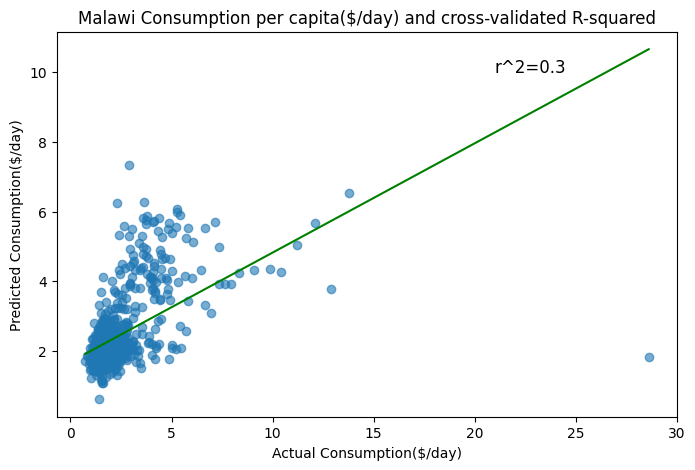

In [25]:
fig = plot_predictions(y_mw, yhat, r2_direct, 'Malawi', max_y=30)

In [26]:
fig.savefig(os.path.join(FIGURES_DIR, 'malawi_result_2016_vgg145.png'))

In [27]:
def plot_predictions_pl(y, yhat, r2, country, max_y=None, yaxis_lower_limit=None, yaxis_upper_limit=None):
    if max_y is not None:
        yhat = yhat[y < max_y]
        y = y[y < max_y]

    # Scatter plot
    scatter_trace = go.Scatter(
        x=y,
        y=yhat,
        mode='markers',
        marker=dict(color='rgba(50, 171, 96, 0.6)'),
        name='Actual vs Predicted'
    )

    # Linear regression line
    slope, intercept = np.polyfit(y, yhat, 1)
    x_fit = np.linspace(min(y), max(y), 100)
    y_fit = slope * x_fit + intercept

    line_trace = go.Scatter(
        x=x_fit,
        y=y_fit,
        mode='lines',
        line=dict(color='rgba(255, 0, 0, 0.8)'),
        name='Regression Line'
    )

    layout = go.Layout(
        title=f'Consumption per capita ($/day) and cross-validated mean R-squared for the Year 2016',
        xaxis=dict(title='Actual Consumption ($/day)'),
        yaxis=dict(title='Predicted Consumption ($/day)'),
        showlegend=True
    )

    # Set y-axis limits to specific values
    layout['yaxis']['range'] = [0, 11]
    layout['xaxis']['range'] = [0, 82]

    # Add R-squared as annotation with increased font size
    annotation = dict(
        x=40,
        y=6.5,
        xref='x',
        yref='y',
        text=f'r^2={round(r2, 1)}',
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40,
        font=dict(size=16)  # Adjust the font size as needed
    )

    fig = go.Figure(data=[scatter_trace, line_trace], layout=layout)
    fig.update_layout(annotations=[annotation])

    return fig

In [28]:
fig = plot_predictions_pl(y_mw, yhat, r2_direct, 'Malawi', max_y=None)
fig.show()

###  Log consumption prediction

In [29]:
def plot_predictions(y, yhat, r2, country, max_y=None):
    if max_y is not None:
        yhat = yhat[y < max_y]
        y = y[y < max_y]
    fig = plt.figure(figsize=(8,5))

    plt.scatter(y, yhat, alpha=0.6)

    plt.plot(np.unique(y), np.poly1d(np.polyfit(y, yhat, 1))(np.unique(y)), color='g')

    plt.text(21, 8.5, f'r^2={round(r2, 1)}', size=12)
    plt.xlabel('Actual Consumption($/day)')
    plt.ylabel('Predicted Consumption($/day)')
    plt.title(f'{country} Consumption per capita($/day) and cross-validated R-squared')
    return fig

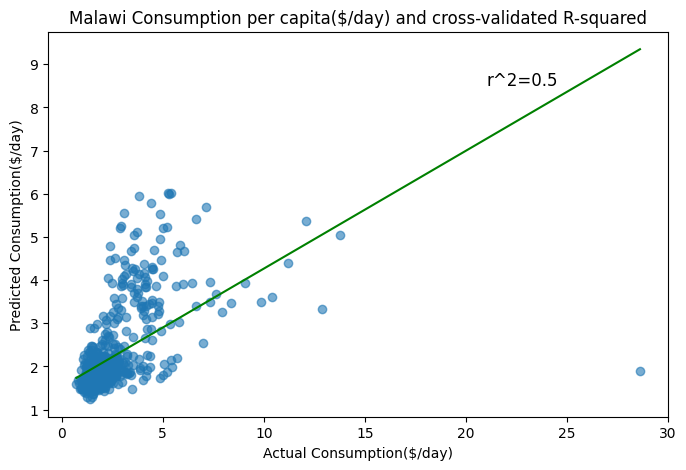

In [30]:
fig = plot_predictions(y_mw,  np.exp(yhat_log), r2_log, 'Malawi', max_y=30)

In [31]:
fig.savefig(os.path.join(FIGURES_DIR, 'malawi_result_2016_vgg145_log.png'))

In [32]:
fig = plot_predictions_pl(y_mw, np.exp(yhat_log), r2_log, 'Malawi', max_y=None)
fig.show()

## Map of actual consumption

### Actual consumption per capita in Malawi for the Year 2016

In [33]:
# Create a scatter mapbox plot
fig = px.scatter_mapbox(df_mw_act_pre, lat="cluster_lat", lon="cluster_lon", color="cons_pc", size="cons_pc",
                        color_continuous_scale="RdYlGn", size_max=20, zoom=6, hover_name="cons_pc")

# Update the layout
fig.update_layout(mapbox_style="carto-positron", coloraxis_colorbar=dict(title="Consumption per capita ($/day)"),
                  mapbox=dict(center=dict(lat=-13.2543, lon=34.3015)))


# Set the width and height
fig.update_layout(
    width=900,  # Specify the desired width in pixels
    height=900  # Specify the desired height in pixels
)

fig.update_layout(
    title="Actual consumption per capita in Malawi for the Year 2016",
    title_font=dict(size=26),
    title_x=0.5,  # Position the title in the middle of the plot horizontally
    title_y=0.97   # Position the title closer to the top of the plot vertically
)

# Show the plot
fig.show()

### Predicted consumption per capita in Malawi for the Year 2016 (without transformation)

In [34]:
# Create a scatter mapbox plot
fig = px.scatter_mapbox(df_mw_act_pre, lat="cluster_lat", lon="cluster_lon", color="predicted", size="predicted",
                        color_continuous_scale="RdYlGn", size_max=8, zoom=6, hover_name="predicted")

# Update the layout
fig.update_layout(mapbox_style="carto-positron", coloraxis_colorbar=dict(title="Consumption per capita ($/day)"),
                  mapbox=dict(center=dict(lat=-13.2543, lon=34.3015)))


# Set the width and height
fig.update_layout(
    width=900,  # Specify the desired width in pixels
    height=900  # Specify the desired height in pixels
)

fig.update_layout(
    title="Predicted consumption per capita in Malawi for the Year 2016 (without transformation)",
    title_font=dict(size=20),
    title_x=0.5,  # Position the title in the middle of the plot horizontally
    title_y=0.97   # Position the title closer to the top of the plot vertically
)

# Show the plot
fig.show()

### Predicted consumption per capita in Malawi for the Year 2016 (log transformation)

In [35]:
# Create a scatter mapbox plot
fig = px.scatter_mapbox(df_mw_act_pre, lat="cluster_lat", lon="cluster_lon", color="LogInverse", size="LogInverse",
                        color_continuous_scale="RdYlGn", size_max=8, zoom=6, hover_name="LogInverse")

# Update the layout
fig.update_layout(mapbox_style="carto-positron", coloraxis_colorbar=dict(title="Consumption per capita ($/day)"),
                  mapbox=dict(center=dict(lat=-13.2543, lon=34.3015)))


# Set the width and height
fig.update_layout(
    width=900,  # Specify the desired width in pixels
    height=900  # Specify the desired height in pixels
)

fig.update_layout(
    title="Predicted consumption per capita in Malawi for the Year 2016 (log transformation)",
    title_font=dict(size=21),
    title_x=0.5,  # Position the title in the middle of the plot horizontally
    title_y=0.97   # Position the title closer to the top of the plot vertically
)

# Show the plot
fig.show()